## Menghubungkan Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import library

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, log_loss
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

## Melihat direktori dataset

In [3]:
# Ganti dengan path folder dataset di Drive Anda
dataset_path = '/content/drive/My Drive/CTU-13-Dataset/1/'
os.listdir(dataset_path)

['botnet-capture-20110810-neris.pcap',
 'Neris.exe',
 'capture20110810.binetflow',
 'README.html']

## Load Dataset

In [4]:
# Path ke file .binetflow
netflow_file = '/content/drive/My Drive/CTU-13-Dataset/1/capture20110810.binetflow'

# Membaca file .binetflow
data = pd.read_csv(netflow_file, sep=',')

# Menampilkan distribusi label
data['Label'].value_counts()

,count
Label,
flow=Background-UDP-Established,1169677
flow=To-Background-UDP-CVUT-DNS-Server,941706
flow=Background-TCP-Established,223543
flow=Background-Established-cmpgw-CVUT,137257
flow=Background-TCP-Attempt,105438
...,...
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-60,1
flow=From-Botnet-V42-TCP-Established-HTTP-Adobe-4,1
flow=From-Botnet-V42-TCP-HTTP-Not-Encrypted-Down-2,1


## Encoding Label(Botnet dan Background)

In [5]:
# Mengubah nilai label: jika mengandung 'Botnet', diberi nilai 1, selain itu 0
data['Label'] = data['Label'].apply(lambda x: 1 if 'Botnet' in x else 0)

In [6]:
data[data['Label'] == 1].head()  # Menampilkan 10 baris pertama

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
675613,2011/08/10 11:04:24.863449,0.000278,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,1
675948,2011/08/10 11:04:27.118993,0.020525,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,1
675953,2011/08/10 11:04:27.140727,0.045125,tcp,147.32.84.165,1027,->,74.125.232.195,80,SRPA_SPA,0.0,0.0,7,882,629,1
690001,2011/08/10 11:06:23.268442,0.336250,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,215,71,1
690036,2011/08/10 11:06:23.606888,3514.083496,tcp,147.32.84.165,1039,->,60.190.222.139,65520,SPA_SPA,0.0,0.0,120,7767,2690,1


## Drop Fitur Startime dan Dir

In [7]:
data.drop(['StartTime', 'Dir'], axis=1, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824636 entries, 0 to 2824635
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Dur       float64
 1   Proto     object 
 2   SrcAddr   object 
 3   Sport     object 
 4   DstAddr   object 
 5   Dport     object 
 6   State     object 
 7   sTos      float64
 8   dTos      float64
 9   TotPkts   int64  
 10  TotBytes  int64  
 11  SrcBytes  int64  
 12  Label     int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 280.2+ MB


## Encode kolom non numerik

In [9]:
# Membuat salinan data untuk menjaga data asli tetap utuh
encoded_data = data.copy()

# Identifikasi kolom non-numerik
non_numeric_columns = ['Proto', 'SrcAddr', 'State', 'Sport', 'DstAddr', 'Dport']

# Lakukan encoding pada setiap kolom non-numerik
label_encoders = {}
for col in non_numeric_columns:
    label_encoders[col] = LabelEncoder()  # Inisialisasi encoder
    encoded_data[col] = label_encoders[col].fit_transform(encoded_data[col])

# Periksa hasil encoding
print(encoded_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824636 entries, 0 to 2824635
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Dur       float64
 1   Proto     int64  
 2   SrcAddr   int64  
 3   Sport     int64  
 4   DstAddr   int64  
 5   Dport     int64  
 6   State     int64  
 7   sTos      float64
 8   dTos      float64
 9   TotPkts   int64  
 10  TotBytes  int64  
 11  SrcBytes  int64  
 12  Label     int64  
dtypes: float64(3), int64(10)
memory usage: 280.2 MB
None


In [10]:
data.head()

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,1.026539,tcp,94.44.127.113,1577,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,0
1,1.009595,tcp,94.44.127.113,1577,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,0
2,3.056586,tcp,147.32.86.89,4768,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,0
3,3.111769,tcp,147.32.86.89,4788,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,0
4,3.083411,tcp,147.32.86.89,4850,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,0


## Visualisasi korelasi antar semua fitur

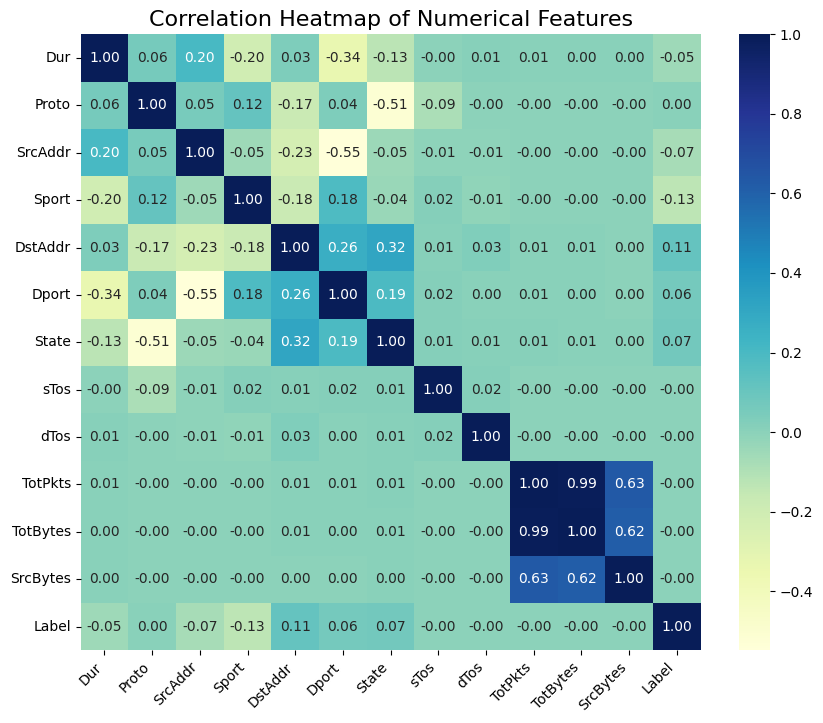

In [11]:
# Memilih hanya kolom numerik untuk korelasi
numerical_features = ['Dur', 'Proto',	'SrcAddr',	'Sport',	'DstAddr',	'Dport',	'State',	'sTos',	'dTos',	'TotPkts',	'TotBytes',	'SrcBytes',	'Label']
numerical_data = encoded_data[numerical_features]

# Menghitung matriks korelasi
correlation_matrix = numerical_data.corr()

# Membuat heatmap menggunakan Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="YlGnBu")

# Menambahkan judul
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [12]:
data.isna().sum()

,0
Dur,0
Proto,0
SrcAddr,0
Sport,9379
DstAddr,0
Dport,4390
State,1
sTos,10590
dTos,195190
TotPkts,0


## Memilih fitur yang memiliki korelasi tinggi dengan label

In [13]:
# Pilih fitur yang diinginkan
selected_features = [ 'Dur', 'Proto', 'DstAddr', 'SrcAddr', 'TotPkts', 'TotBytes', 'SrcBytes', 'Label']

# Membuat DataFrame baru dengan hanya fitur-fitur tersebut
filtered_data = encoded_data[selected_features]

# Tampilkan DataFrame yang sudah difilter
filtered_data.head()

,Dur,Proto,DstAddr,SrcAddr,TotPkts,TotBytes,SrcBytes,Label
0,1.026539,11,21316,505974,4,276,156,0
1,1.009595,11,21316,505974,4,276,156,0
2,3.056586,11,77982,86960,3,182,122,0
3,3.111769,11,77982,86960,3,182,122,0
4,3.083411,11,77982,86960,3,182,122,0


In [14]:
# Membuat objek LabelEncoder
label_encoder = LabelEncoder()

# Melakukan encoding pada kolom 'Proto'
filtered_data['Proto'] = label_encoder.fit_transform(filtered_data['Proto'])

# Tampilkan DataFrame setelah Label Encoding
filtered_data.head()

<ipython-input-14-20b52335184a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Proto'] = label_encoder.fit_transform(filtered_data['Proto'])


,Dur,Proto,DstAddr,SrcAddr,TotPkts,TotBytes,SrcBytes,Label
0,1.026539,11,21316,505974,4,276,156,0
1,1.009595,11,21316,505974,4,276,156,0
2,3.056586,11,77982,86960,3,182,122,0
3,3.111769,11,77982,86960,3,182,122,0
4,3.083411,11,77982,86960,3,182,122,0


## Visualisasi korelasi antar fitur yang dipilih

<Axes: >

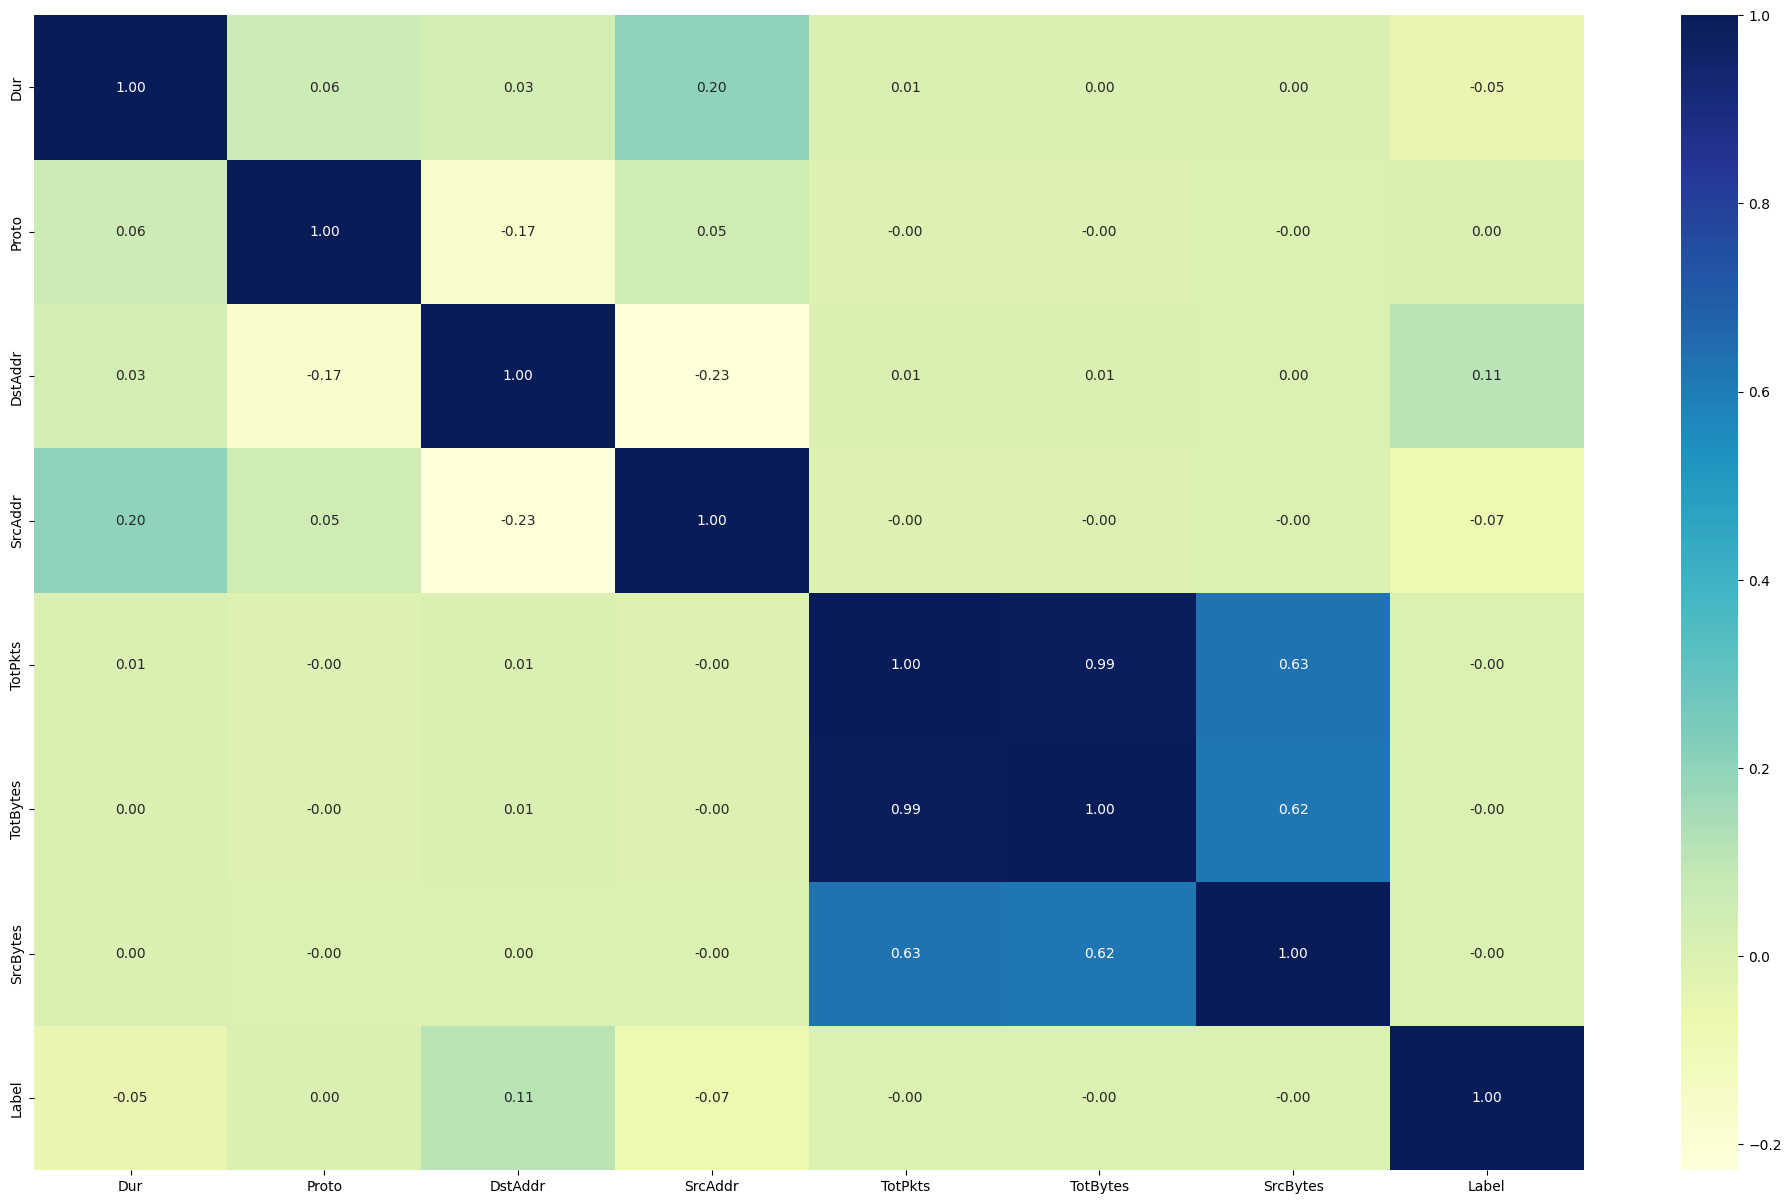

In [15]:
cm = filtered_data.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu")

## Split, normalisasi, dan oversampling data

In [16]:
# Memisahkan fitur dan label
X = filtered_data
y = filtered_data['Label']  # pastikan label sudah ter-encode

# Membagi data menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data (fitur)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Mengecek distribusi kelas sebelum oversampling
print("Distribusi sebelum oversampling:", Counter(y_train))

# Oversampling menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Mengecek distribusi kelas setelah oversampling
print("Distribusi setelah oversampling:", Counter(y_train_res))

Distribusi sebelum oversampling: Counter({0: 2227008, 1: 32700})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Distribusi setelah oversampling: Counter({0: 2227008, 1: 2227008})


## Training data dengan model MLP dan Testing data

In [17]:
# Model MLPClassifier dari scikit-learn
model = MLPClassifier(hidden_layer_sizes=(3,), max_iter=300, activation='relu', solver='adam', alpha=0.001, random_state=42)

model.fit(X_train, y_train)

# Prediksi pada data latih dan uji
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

## Evaluasi data latih dan data uji

In [18]:
# Evaluasi pada data latih
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Evaluasi pada data uji
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Confusion Matrix untuk data latih dan uji
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Cross-validation Accuracy: 1.0000 (+/- 0.0000)


## Visualisasi dan hasil evaluasi model

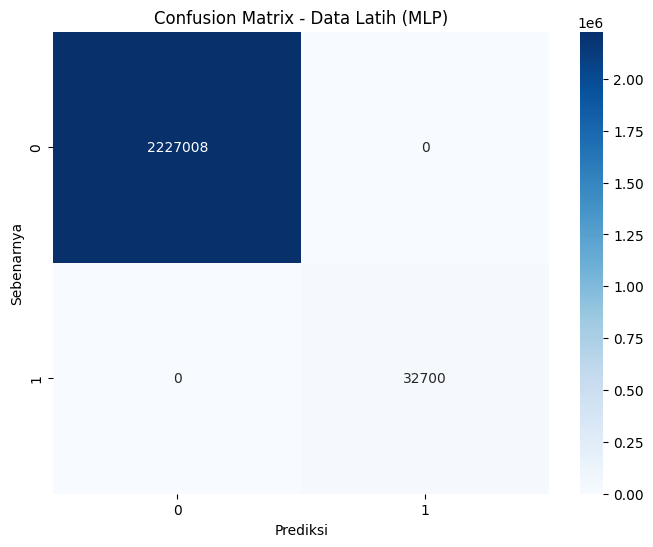

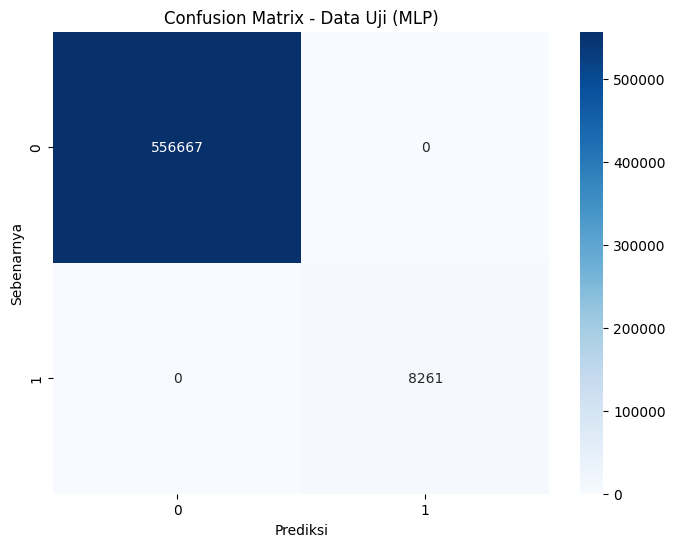

=== Evaluasi MLP ===
Akurasi Data Latih: 1.0000
F1-Score Data Latih: 1.0000
Akurasi Data Uji: 1.0000
F1-Score Data Uji: 1.0000
Training Loss: 0.0000
Validation Loss: 0.0000
Cross-validation Accuracy: 1.0000 (+/- 0.0000)
ROC-AUC: 1.0000


In [19]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Prediksi
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Jika model mendukung probabilitas
    if hasattr(model, 'predict_proba'):
        y_train_prob = model.predict_proba(X_train)
        y_test_prob = model.predict_proba(X_test)
        train_loss = log_loss(y_train, y_train_prob)
        test_loss = log_loss(y_test, y_test_prob)
    else:
        # Gunakan prediksi langsung untuk menghitung error jika tidak ada probabilitas
        train_loss = log_loss(y_train, model.predict(X_train))
        test_loss = log_loss(y_test, model.predict(X_test))

    # Evaluasi pada data latih
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    # Evaluasi pada data uji
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Confusion Matrix
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Data Latih ({model_name})")
    plt.xlabel("Prediksi")
    plt.ylabel("Sebenarnya")
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Data Uji ({model_name})")
    plt.xlabel("Prediksi")
    plt.ylabel("Sebenarnya")
    plt.show()

    # Menampilkan hasil evaluasi
    print(f"=== Evaluasi {model_name} ===")
    print(f"Akurasi Data Latih: {train_accuracy:.4f}")
    print(f"F1-Score Data Latih: {train_f1:.4f}")
    print(f"Akurasi Data Uji: {test_accuracy:.4f}")
    print(f"F1-Score Data Uji: {test_f1:.4f}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {test_loss:.4f}")
    print(f"Cross-validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    if hasattr(model, 'predict_proba'):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"ROC-AUC: {roc_auc:.4f}")
    print("="*40)

evaluate_model(model, X_train, y_train, X_test, y_test, "MLP")